In [315]:
import tensorflow as tf

In [316]:
def normalise(X_train, X_test):
    X_train = X_train / 255.0
    X_train = tf.cast(X_train, dtype=tf.float32)
    
    X_test = X_test / 255.0
    X_test = tf.cast(X_test, dtype=tf.float32)

    return X_train, X_test

def limit_size(train, test, size):
    train = (train[0][:size[0]], train[1][:size[0]])
    test = (test[0][:size[1]], test[1][:size[1]])
    return train, test

def load_mnist(size=()):
    (X_train, y_train), (X_test , y_test) = tf.keras.datasets.mnist.load_data()
    X_train, X_test = normalise(X_train, X_test)

    # shape : (None, 28,28) to (None, 28,28,1)
    X_train = tf.expand_dims(X_train, axis=-1)
    X_test = tf.expand_dims(X_test, axis=-1)

    if size:
        return limit_size((X_train, y_train), (X_test , y_test), size) 
    return (X_train, y_train), (X_test , y_test)

def load_fashion_mnist(size=()):
    (X_train, y_train), (X_test , y_test) = tf.keras.datasets.fashion_mnist.load_data()
    X_train, X_test = normalise(X_train, X_test)

    # shape : (None, 28,28) to (None, 28,28,1)
    X_train = tf.expand_dims(X_train, axis=-1)
    X_test = tf.expand_dims(X_test, axis=-1)

    if size:
        return limit_size((X_train, y_train), (X_test , y_test), size) 
    return (X_train, y_train), (X_test , y_test)

def load_cifar_10(size=()):
    (X_train, y_train), (X_test , y_test) = tf.keras.datasets.cifar10.load_data()
    X_train, X_test = normalise(X_train, X_test)
    if size:
        return limit_size((X_train, y_train), (X_test , y_test), size)
    return (X_train, y_train), (X_test , y_test)

def load_cifar_100(size=()):
    (X_train, y_train), (X_test , y_test) = tf.keras.datasets.cifar100.load_data()
    X_train, X_test = normalise(X_train, X_test)
    if size:
        return limit_size((X_train, y_train), (X_test , y_test), size)
    return (X_train, y_train), (X_test , y_test)

=== Generation 1/1
crossover created 0 offspring(s)
mutation created 0 offspring(s)
local search created 0 offspring(s)
Len of pop after manipulations : 1
Fitting individual 1/1 with genotype {'epochs': 9, 'epsilon': 0.09731398228248041, 'm_plus': 0.9698413115109902, 'm_minus': 0.10338347177244572, 'lambda_': 0.3484201017237299, 'alpha': 0.00819286796763913, 'r': 2, 'no_of_conv_kernels': 128, 'no_of_primary_capsules': 32, 'no_of_secondary_capsules': 10, 'primary_capsule_vector': 8, 'secondary_capsule_vector': 16}


Epoch 9/9: 100%|██████████| 16/16 [00:04<00:00,  3.81it/s, Loss : 0.0024]


Len of pop after selection : 1
Fitting individual 1/1 with genotype {'epochs': 9, 'epsilon': 0.09731398228248041, 'm_plus': 0.9698413115109902, 'm_minus': 0.10338347177244572, 'lambda_': 0.3484201017237299, 'alpha': 0.00819286796763913, 'r': 2, 'no_of_conv_kernels': 128, 'no_of_primary_capsules': 32, 'no_of_secondary_capsules': 10, 'primary_capsule_vector': 8, 'secondary_capsule_vector': 16}


Epoch 9/9: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s, Loss : 0.0024]


Optimal solution(s):
[[9.00000000e+00 9.73139823e-02 9.69841312e-01 1.03383472e-01
  3.48420102e-01 8.19286797e-03 2.00000000e+00]]
______________
Fitness values:
  Inference    Accuracy
[[5.48994493 0.95703125]]
=== GA done : 2023-07-07 14:45:33.595196 ===


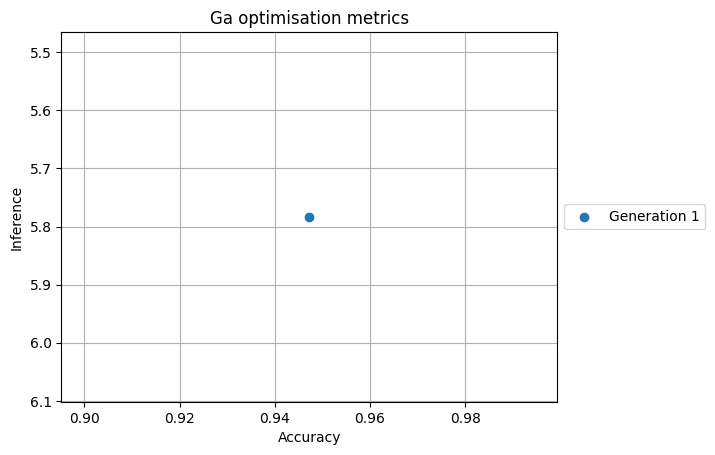

In [320]:
from datetime import datetime
from sklearn.metrics import accuracy_score
import time
from src.CapsNet import CapsNet
import numpy as np
import random as rn
import matplotlib.pyplot as plt


class Nsga_II:
    def __init__(self, n_gen, pop_size, rate_crossover, rate_mutation, rate_local_search, step_size, train_data, test_data) -> None:
        """NSGA-II pareto dominance class for optimising inference and accuracy of CapsNet

        Args:
            n_gen (int): Number of generations
            pop_size (int): Number of individuals in the population
            rate_crossover (int): Rate of crossovers (higher = more frequent)
            rate_mutation (int): Rate of mutations (higher = more frequent)
            rate_local_search (int): Rate of local searches (higher = more frequent)
            step_size (float): Step used for local search
            train_data (tupple): train_data[0] = X_train, train_data[1] = y_train
            test_data (tupple): test_data[0] = X_test, test_data[1] = y_test
        """
        self.n_gen = n_gen
        self.pop_size = pop_size
        self.rate_crossover = rate_crossover
        self.rate_mutation = rate_mutation
        self.rate_local_search = rate_local_search
        self.step_size = step_size
        self.train_data = train_data
        self.test_data = test_data

        self.n_var = 7
        self.vars = ['epochs', 'epsilon', 'm_plus', 'm_minus', 'lambda_', 'alpha', 'r']
        self.mins = [1, 0.01, 0.9, 0.05, 0.1, 0.0001, 2]
        self.maxs = [10, 0.1, 0.99, 0.2, 1.0, 0.01, 5]

        self.time_start = None


    def random_pop(self):
        """Initialise pop_size random individuals

        Returns:
            array of shape=(self.pop_size, self.n_var): initialised population
        """
        pop = np.zeros((self.pop_size, self.n_var))
        for i in range(self.pop_size):
            # making sure the epochs and r are integers.
            pop[i][0] = np.random.randint(self.mins[0], self.maxs[0])
            pop[i][-1] = np.random.randint(self.mins[-1], self.maxs[-1])
            for j in range(1, self.n_var - 1):
                pop[i][j] = np.random.uniform(self.mins[j], self.maxs[j])
        return pop

    # Get two parents from the population
    def select_random_parents(self, pop):
        """Get two random parents from the population

        Args:
            pop (np.array): Population pool

        Returns:
            np.array, np.array: parent1 and parent2
        """
        r1 = np.random.randint(0, pop.shape[0])
        r2 = np.random.randint(0, pop.shape[0])
        while r1 == r2: # make sure we have two different parents
            r1 = np.random.randint(0, pop.shape[0])
            r2 = np.random.randint(0, pop.shape[0])
        return pop[r1], pop[r2]

    def crossover(self, pop):
        """Randomly generates 2 crossover offsprings from 2 parents by mixing their genes
        The crossover occurs depending on the crossover rate. (higher = more likely)

        Args:
            pop (np.array): population

        Returns:
            np.array: offsprings ready to be added to the population
        """
        offsprings = []
        for _ in range(int(self.pop_size / 2)):
            if self.rate_crossover > np.random.rand():
                p1, p2 = self.select_random_parents(pop)
                crossover_point = np.random.randint(1, pop.shape[1])
                o1 = np.append(p1[:crossover_point], p2[crossover_point:])
                o2 = np.append(p2[:crossover_point], p1[crossover_point:])
                offsprings.append(o1)
                offsprings.append(o2)
        print(f'crossover created {len(offsprings)} offspring(s)')
        return np.array(offsprings)

    def mutation(self, pop):
        """on each itteration, if the mutation occurs,
        out of 2 randomly selected parents, create 2 offsprings by exchanging one gene between parents

        Args:
            pop (np.array): population

        Returns:
            np.array: offsprings ready to be added to the population
        """
        offsprings = []
        for i in range(int(self.pop_size / 2)):
            if self.rate_mutation > np.random.rand():
                p1, p2 = self.select_random_parents(pop)
                cutting_point = np.random.randint(0, pop.shape[1])
                o1 = p1
                o2 = p2
                save = p1[cutting_point]
                o1[cutting_point] = p2[cutting_point]
                o2[cutting_point] = save
                offsprings.append(o1)
                offsprings.append(o2)
        print(f'mutation created {len(offsprings)} offspring(s)')
        return np.array(offsprings)

    def local_search(self, pop):
        """On each itteration if the local search occurs,
        create one offspring by adding fixed coordinates displacement to a randomly selected parent's genes

        Args:
            pop (np.array): population

        Returns:
            np.array: offsprings ready to be added to the population
        """
        offsprings = []
        for _ in range(int(self.pop_size / 2)):
            if self.rate_local_search > np.random.rand():
                r1 = np.random.randint(0, pop.shape[0])
                offspring = pop[r1, :]
                r2 = np.random.randint(0, pop.shape[1])
                offspring[r2] += np.random.uniform(-self.step_size, self.step_size)
                # make sure we stay in bounds
                if offspring[r2] < self.mins[r2]:
                    offspring[r2] = self.mins[r2]
                if offspring[r2] > self.maxs[r2]:
                    offspring[r2] = self.maxs[r2]
                offsprings.append(offspring)
        print(f'local search created {len(offsprings)} offspring(s)')
        return np.array(offsprings)

    def evaluation(self, pop):
        """Create a CapsNet model for each individual in the population,
        evaluate it inference time and accuracy.

        Args:
            pop (np.array): population

        Returns:
            np.array: fitness values with index 0 = inference time and index 1 = accuracy
        """
        fitness_values = np.zeros((len(pop), 2))
        for i, ind in enumerate(pop):
            genotype = {key: value for key, value in zip(self.vars, ind)}
            # making sure we have integer values for epochs and rounds
            genotype['epochs'] = round(genotype['epochs'])
            genotype['r'] = round(genotype['r'])
            # TODO
            genotype['no_of_conv_kernels'] = 128
            genotype['no_of_primary_capsules'] = 32
            genotype['no_of_secondary_capsules'] = 10
            genotype['primary_capsule_vector'] = 8
            genotype['secondary_capsule_vector'] = 16
            
            # build model with found genotype
            model = CapsNet(**genotype)
            print(f'Fitting individual {i + 1}/{len(pop)} with genotype {genotype}')
            model.fit(self.train_data[0], self.train_data[1], tf.keras.optimizers.legacy.Adam())

            # evaluate model
            start = time.time()
            y_preds = model.predict(self.test_data[0])
            end = time.time()
            inference = end - start
            accuracy = accuracy_score(self.test_data[1], y_preds)

            fitness_values[i,0] = inference
            fitness_values[i,1] = accuracy
        return fitness_values

    def pareto_front_finding(self, fitness_values, pop_index):
        """Get the indeces of the best individuals
        The best individuals maximise the accuracy and minimise the inference time

        Args:
            fitness_values (np.array): population fitnesses
            pop_index (np.array): indeces of the population

        Returns:
            np.array: The most fit individuals
        """
        pop_size = fitness_values.shape[0]
        pareto_front = np.ones(pop_size, dtype=bool)
        for i in range(pop_size):
            for j in range(pop_size): # a solution is dominant if the inference is lower and the accuracy higher
                if (fitness_values[j][0] <= fitness_values[i][0] and fitness_values[j][1] >= fitness_values[i][1]) and \
                        (fitness_values[j][0] < fitness_values[i][0] or fitness_values[j][1] > fitness_values[i][1]):
                    pareto_front[i] = 0
                    break
        return pop_index[pareto_front]

    # Estimate how tightly clumped fitness values are on Pareto front. 
    def crowding_calculation(self, fitness_values):
        """Estimates how close some fitness values are

        Args:
            fitness_values (np.array): population fitnesses

        Returns:
            float: crowding distance
        """
        pop_size = len(fitness_values[:, 0])
        fitness_value_number = len(fitness_values[0, :])
        matrix_for_crowding = np.zeros((pop_size, fitness_value_number))
        normalized_fitness_values = (fitness_values - fitness_values.min(0))/fitness_values.ptp(0)
        
        for i in range(fitness_value_number):
            crowding_results = np.zeros(pop_size)
            crowding_results[0] = 1
            crowding_results[pop_size - 1] = 1
            sorted_normalized_fitness_values = np.sort(normalized_fitness_values[:,i])
            sorted_normalized_values_index = np.argsort(normalized_fitness_values[:,i])
            crowding_results[1:pop_size - 1] = (sorted_normalized_fitness_values[2:pop_size] - sorted_normalized_fitness_values[0:pop_size - 2])
            re_sorting = np.argsort(sorted_normalized_values_index)
            matrix_for_crowding[:, i] = crowding_results[re_sorting]
        
        crowding_distance = np.sum(matrix_for_crowding, axis=1)
        return crowding_distance

    def remove_using_crowding(self, fitness_values, number_solutions_needed):
        """Removes the solutions that are too close to ensure diversity on the Pareto front

        Args:
            fitness_values (np.array): population fitnesses
            number_solutions_needed (int): number of solutions needed

        Returns:
            np.array: remaining individuals
        """
        pop_index = np.arange(fitness_values.shape[0])
        crowding_distance = self.crowding_calculation(fitness_values)
        selected_pop_index = np.zeros(number_solutions_needed)
        selected_fitness_values = np.zeros((number_solutions_needed, len(fitness_values[0, :])))    # arr(num_sol_needed x 2)
        for i in range(number_solutions_needed):
            pop_size = pop_index.shape[0]
            solution_1 = rn.randint(0, pop_size - 1)
            solution_2 = rn.randint(0, pop_size - 1)
            if crowding_distance[solution_1] >= crowding_distance[solution_2]:
                # solution 1 is better than solution 2
                selected_pop_index[i] = pop_index[solution_1]
                selected_fitness_values[i, :] = fitness_values[solution_1, :]
                pop_index = np.delete(pop_index, (solution_1), axis=0)
                fitness_values = np.delete(fitness_values, (solution_1), axis=0)
                crowding_distance = np.delete(crowding_distance, (solution_1), axis=0)
            else:
                # solution 2 is better than solution 1
                selected_pop_index[i] = pop_index[solution_2]
                selected_fitness_values[i, :] = fitness_values[solution_2, :]
                pop_index = np.delete(pop_index, (solution_2), axis=0)
                fitness_values = np.delete(fitness_values, (solution_2), axis=0)
                crowding_distance = np.delete(crowding_distance, (solution_2), axis=0)
        
        selected_pop_index = np.asarray(selected_pop_index, dtype=int)
        return selected_pop_index

    def selection(self, pop, fitness_values):
        """Perform pareto front selection to have a population equal to pop_size

        Args:
            pop (np.array): populationb
            fitness_values (np.array): current population fitnesses

        Returns:
            np.array: selected population
        """
        pareto_front_index = []

        pop_index_0 = np.arange(self.pop_size)
        pop_index = np.arange(self.pop_size)
        
        while len(pareto_front_index) < self.pop_size:
            new_pareto_front = self.pareto_front_finding(fitness_values[pop_index_0, :], pop_index_0)
            total_pareto_size = len(pareto_front_index) + len(new_pareto_front)

            # check the size of pareto_front, if larger than pop_size then remove some
            if total_pareto_size > self.pop_size:
                number_solutions_needed = self.pop_size - len(pareto_front_index)
                selected_solutions = self.remove_using_crowding(fitness_values[new_pareto_front], number_solutions_needed)
                new_pareto_front = new_pareto_front[selected_solutions]
            
            pareto_front_index = np.hstack((pareto_front_index, new_pareto_front))
            remaining_index = set(pop_index) - set(pareto_front_index)
            pop_index_0 = np.array(list(remaining_index))

        selected_pop = pop[pareto_front_index.astype(int)]
        return selected_pop

    def plot_nsga(self, metrics):
        """Saves a scatter plot of the fitnesses in ./saved_ga

        Args:
            metrics (list(dict)): nas metrics
        """
        fig, ax = plt.subplots()
        for key, value in metrics.items():
            x = [v['accuracy'] for v in value]
            y = [v['inference'] for v in value]
            plt.scatter(x, y, label=key)

        legend = ax.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=(len(metrics) + 9) // 10)
        ax.set_title('Ga optimisation metrics')
        ax.grid('on')
        ax.set_xlabel('Accuracy')
        ax.set_ylabel('Inference')
        ax.invert_yaxis()

        fig.savefig(f'{time.time()}.png', bbox_extra_artists=(legend,), bbox_inches='tight')

    def optimise(self):
        """Performs self.n_gen itterations of evolutionary algorithm to optimise population

        Returns:
            list: Best individuals found
        """
        self.time_start = datetime.now()
        pop = self.random_pop()
        metrics = {}
        for i in range(self.n_gen):
            print(f"=== Generation {i+1}/{self.n_gen}")

            crossover_offsprings = self.crossover(pop)
            mutation_offsprings = self.mutation(pop)
            local_search_offsprings = self.local_search(pop)
            if crossover_offsprings.size > 0:
                pop = np.append(pop, crossover_offsprings, axis=0)
            if mutation_offsprings.size > 0:
                pop = np.append(pop, mutation_offsprings, axis=0)
            if local_search_offsprings.size > 0:
                pop = np.append(pop, local_search_offsprings, axis=0)

            print(f"Len of pop after manipulations : {len(pop)}")
            fitness_values = self.evaluation(pop)
            metrics[f'Generation {i+1}'] = [{"inference": value[0], "accuracy": value[1]} for value in fitness_values]


            pop = self.selection(pop, fitness_values)
            print(f"Len of pop after selection : {len(pop)}")
        fitness_values = self.evaluation(pop)
        index = np.arange(pop.shape[0]).astype(int)
        pareto_front_index = self.pareto_front_finding(fitness_values, index)
        pop = pop[pareto_front_index, :]
        self.plot_nsga(metrics)
        print("Optimal solution(s):")
        print(pop)
        fitness_values = fitness_values[pareto_front_index]
        print("______________")
        print("Fitness values:")
        print("  Inference    Accuracy")
        print(fitness_values)
        print(f"=== GA done : {datetime.now()} ===")

(X_train, y_train), (X_test , y_test) = load_mnist(size=(1024, 512))

params = {
    'n_gen': 1,
    'pop_size': 1,
    'rate_crossover': 0.7,
    'rate_mutation': 0.1,
    'rate_local_search': 0.5,
    'step_size': 0.1,
    'train_data': (X_train, y_train),
    'test_data': (X_test, y_test)
}

nas = Nsga_II(**params)

nas.optimise()  